Image Processing
================

Welcome to the quickstart guide for dask-image.

1. [Setting up your environment](#environment_setup)
1. [Importing dask-image](#imports)
1. [Getting the example data](#example_data)
1. [Reading in image data](#reading_image_data)
    1. [Reading a single image](#reading_a_single_image)
    1. [Reading multiple images](#reading_multiple_images)

1. [Applying your own custom function to images](#applying_custom_function)
    1. [Embarrassingly parallel problems](#embarrassingly_parallel)

1. [Joining partial images together](#joining_images)

1. [A segmentation analysis pipeline](#segmentation_pipeline)
    1. [Filtering](#filtering)
    1. [Segmenting](#segmenting)
    1. [Analyzing](#analyzing)
1. [Next steps](#next_steps)
1. [Cleaning up temporary directories and files]('#cleanup)

<a id='environment_setup'></a>
## Setting up your environment

### Install Extra Dependencies

We first install the library scikit-image for easier access to the example image data there.

In [1]:
!pip install scikit-image --upgrade-strategy only-if-needed

If you are running this notebook on your own computer and not in the mybinder environment, you'll additionally need to ensure your Python environment contains:
* dask
* dask-image
* python-graphviz
* scikit-image
* matplotlib
* numpy

You can refer to the full list of dependencies used for the `dask-examples` repository, available in the [`binder/environment.yml` file here](https://github.com/dask/dask-examples/blob/master/binder/environment.yml
) (note that the `nomkl` package is not available for Windows users): https://github.com/dask/dask-examples/blob/master/binder/environment.yml


<a id='imports'></a>
## Importing dask-image

When you import dask-image, be sure to use an underscore instead of a dash between the two words.

In [2]:
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da

We'll also use matplotlib to display image results in this notebook.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

<a id='example_data'></a>
## Getting the example data

We'll use some example image data from the scikit-image library in this tutorial. These images are very small, but will allow us to demonstrate the functionality of dask-image. 

Let's download and save a public domain image of the astronaut Eileen Collins to a temporary directory. This image was originally downloaded from the NASA Great Images database <https://flic.kr/p/r9qvLn>, but we'll access it with scikit-image's `data.astronaut()` method.

In [4]:
!mkdir temp

In [5]:
import os
from skimage import data, io

output_filename = os.path.join('temp', 'astronaut.png')
io.imsave(output_filename, data.astronaut())

Really large datasets often can't fit all of the data into a single file, so we'll chop this image into four parts and save the image tiles to a second temporary directory. This will give you a better idea of how you can use dask-image on a real dataset.

In [6]:
!mkdir temp-tiles

In [7]:
io.imsave(os.path.join('temp-tiles', 'image-00.png'), data.astronaut()[:256, :256, :])  # top left
io.imsave(os.path.join('temp-tiles', 'image-01.png'), data.astronaut()[:256, 256:, :])  # top right
io.imsave(os.path.join('temp-tiles', 'image-10.png'), data.astronaut()[256:, :256, :])  # bottom left
io.imsave(os.path.join('temp-tiles', 'image-11.png'), data.astronaut()[256:, 256:, :])  # bottom right

Now we have some data saved, let's practise reading in files with dask-image and processing our images.

<a id='reading_image_data'></a>
## Reading in image data

<a id='reading_a_single_image'></a>
### Reading a single image

Let's load a public domain image of the astronaut Eileen Collins with dask-image [imread()](http://image.dask.org/en/latest/dask_image.imread.html). This image was originally downloaded from the NASA Great Images database <https://flic.kr/p/r9qvLn>.

In [8]:
import os
filename = os.path.join('temp', 'astronaut.png')
print(filename)

temp/astronaut.png


dask.array<from-value, shape=(1, 512, 512, 3), dtype=uint8, chunksize=(1, 512, 512, 3), chunktype=numpy.ndarray>


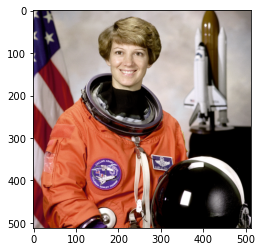

In [9]:
astronaut = dask_image.imread.imread(filename)
print(astronaut)
plt.imshow(astronaut[0, ...])  # display the first (and only) frame of the image

This has created a dask array with `shape=(1, 512, 512, 3)`. This means it contains one image frame with 512 rows, 512 columns, and 3 color channels. 

Since the image is relatively small, it fits entirely within one dask-image chunk, with `chunksize=(1, 512, 512, 3)`.


<a id='reading_multiple_images'></a>
### Reading multiple images

In many cases, you may have multiple images stored on disk, for example:
`image_00.png`, `image_01.png`, ... `image_NN.png`. These can be read into a dask array as multiple image frames.

Here we have the astronaut image split into four non-overlapping tiles:
* `image_00.png` = top left image (index 0,0)
* `image_01.png` = top right image (index 0,1)
* `image_10.png` = bottom left image (index 1,0)
* `image_11.png` = bottom right image (index 1,1)

This filename pattern can be matched with regex: `image-*.png`

In [10]:
!ls temp-tiles

image-00.png  image-01.png  image-10.png  image-11.png


In [11]:
import os
filename_pattern = os.path.join('temp-tiles', 'image-*.png')
tiled_astronaut_images = dask_image.imread.imread(filename_pattern)
print(tiled_astronaut_images)

dask.array<concatenate, shape=(4, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3), chunktype=numpy.ndarray>


This has created a dask array with `shape=(4, 256, 256, 3)`. This means it contains four image frames; each with 256 rows, 256 columns, and 3 color channels. 

There are four chunks in this particular case. Each image frame here is a separate chunk with `chunksize=(1, 256, 256, 3)`.

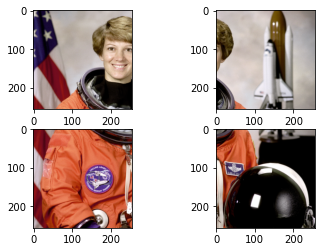

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(tiled_astronaut_images[0])
ax[0,1].imshow(tiled_astronaut_images[1])
ax[1,0].imshow(tiled_astronaut_images[2])
ax[1,1].imshow(tiled_astronaut_images[3])
plt.show()

<a id='applying_custom_function'></a>
## Applying your own custom function to images

Next you'll want to do some image processing, and apply a function to your images.

We'll use a very simple example: converting an RGB image to grayscale. But you can also use this method to apply arbittrary functions to dask images. To convert our image to grayscale, we'll use the equation to calcuate luminance ([reference pdf](http://www.poynton.com/PDFs/ColorFAQ.pdf))": 

`Y = 0.2125 R + 0.7154 G + 0.0721 B` 

We'll write the function for this equation as follows:

In [13]:
def grayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) + 
              (rgb[..., 1] * 0.7154) + 
              (rgb[..., 2] * 0.0721))
    return result

Let's apply this function to the astronaut image we read in as a single file and visualize the computation graph. 

(Visualizing the computation graph isn't necessary most of the time but it's helpful to know what dask is doing under the hood, and it can also be very useful for debugging problems.)

dask.array<add, shape=(1, 512, 512), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>


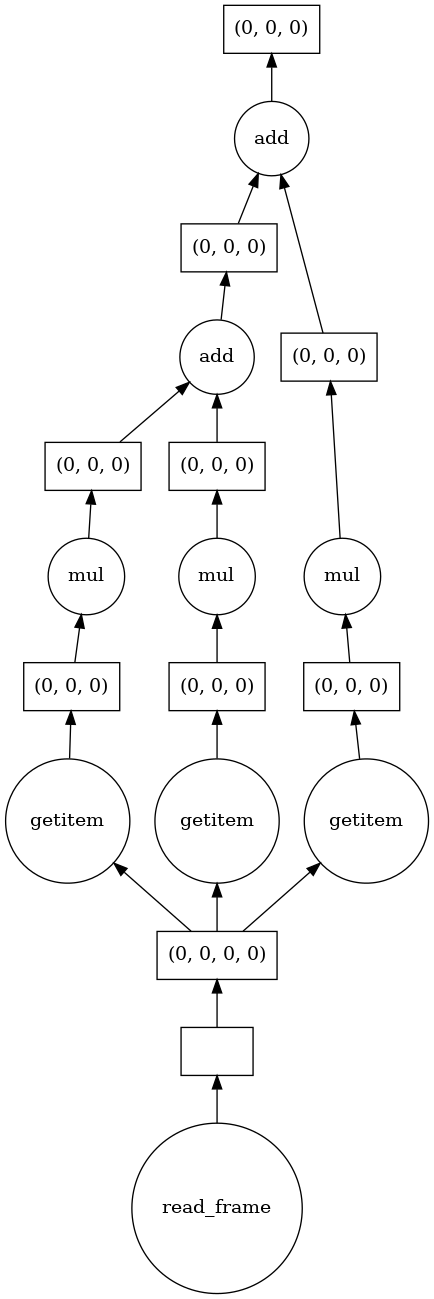

In [14]:
single_image_result = grayscale(astronaut)
print(single_image_result)
single_image_result.visualize()

We also see that there are no longer three color channels in the shape of the result, and that the output image is as expected.

Original image dimensions:  (1, 512, 512, 3)
Processed image dimensions: (1, 512, 512)


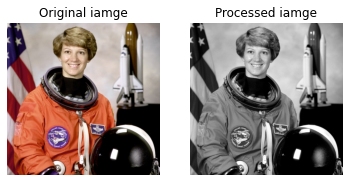

In [15]:
print("Original image dimensions: ", astronaut.shape)
print("Processed image dimensions:", single_image_result.shape)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(astronaut[0, ...])            # display the first (and only) frame of the image
ax1.imshow(single_image_result[0, ...], cmap='gray')  # display the first (and only) frame of the image

# Subplot headings
ax0.set_title('Original iamge')
ax1.set_title('Processed iamge')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

<a id='embarrassingly_parallel'></a>
### Embarrassingly parallel problems

The syntax is identical to apply a function to multiple images or dask chunks. This is an example of an embarrassingly parallel problem, and we see that dask automatically creates a computation graph for each chunk.


dask.array<add, shape=(4, 256, 256), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>


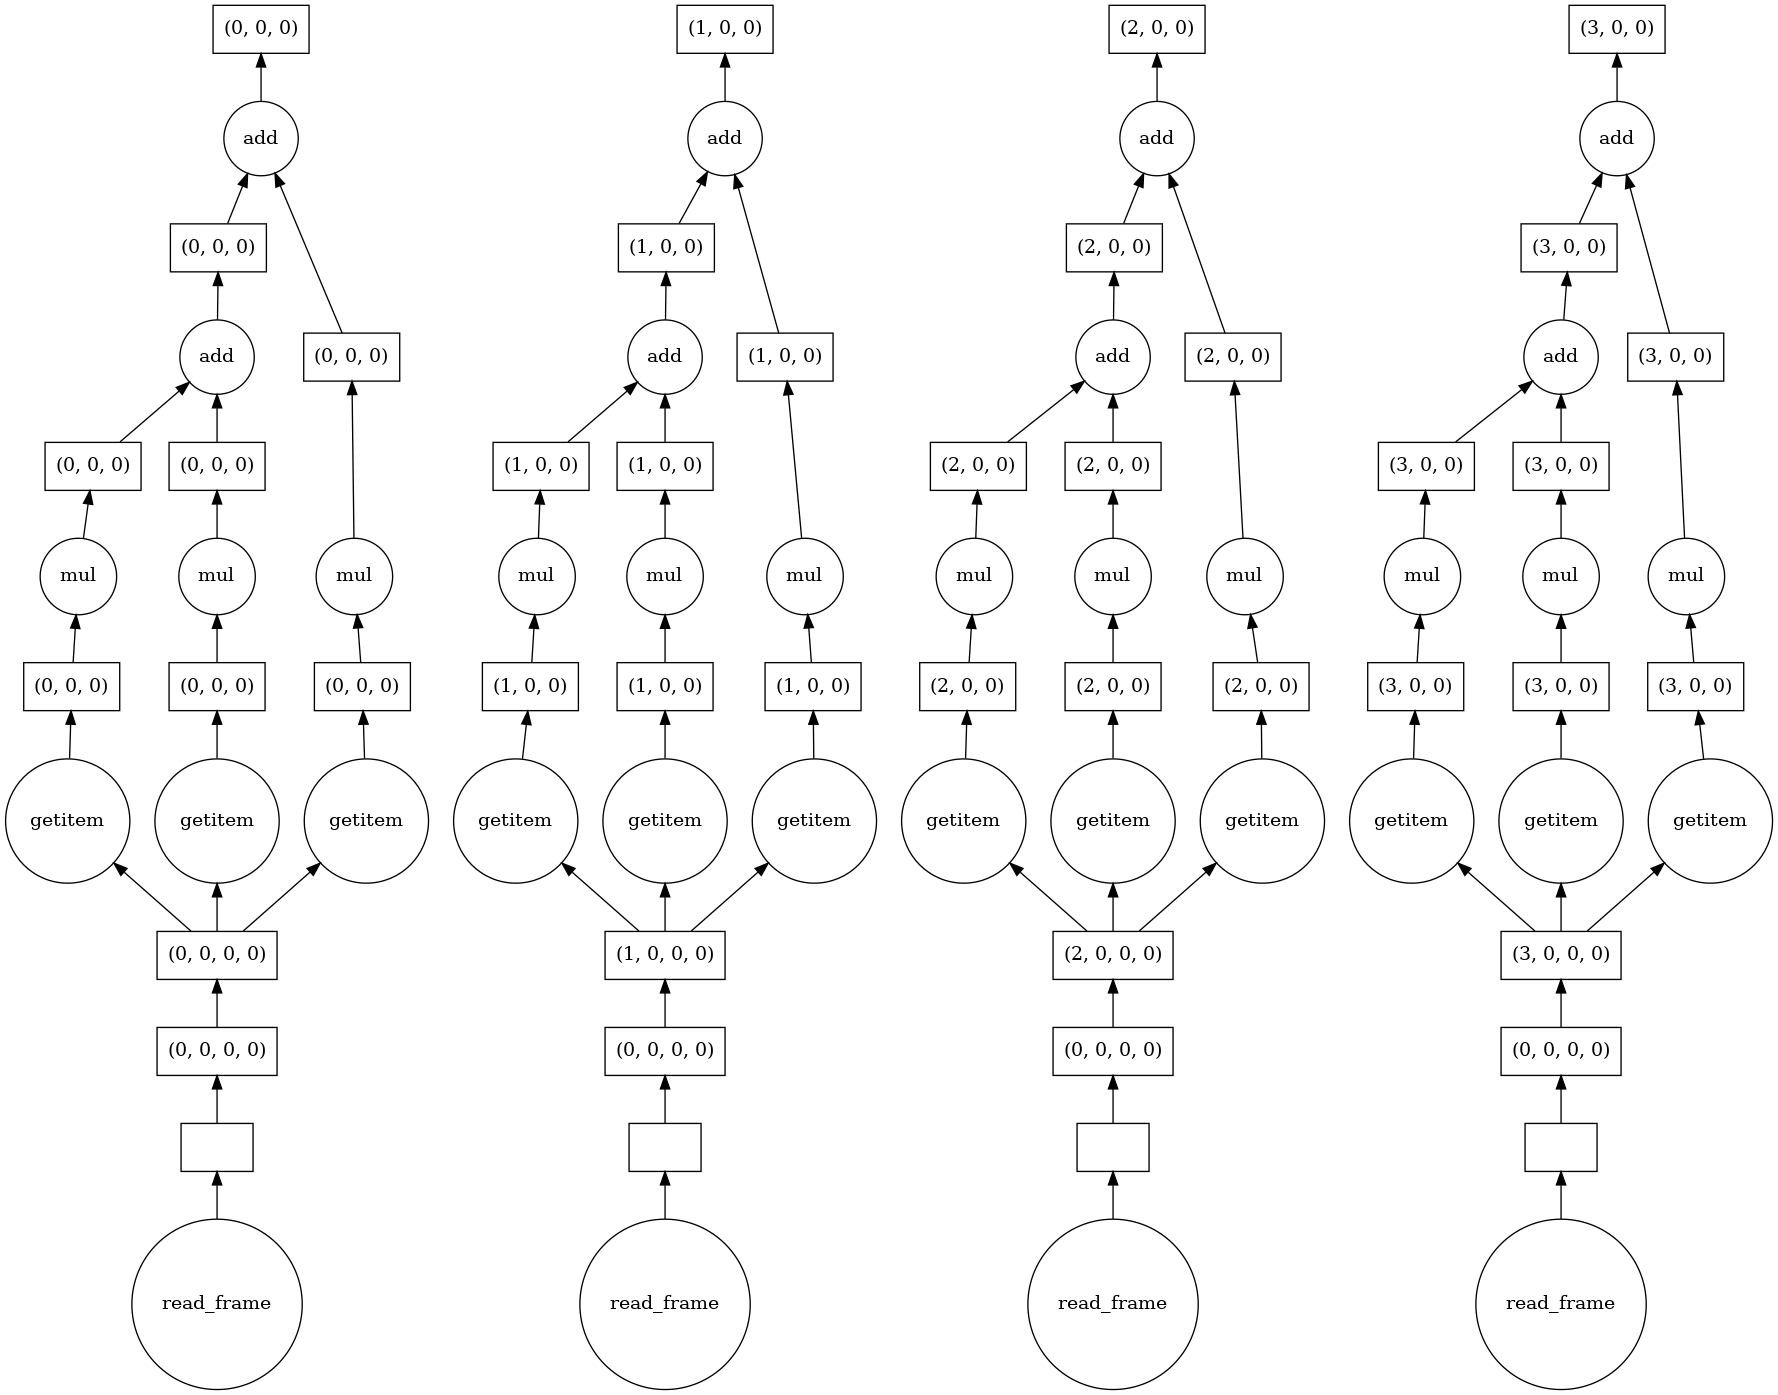

In [16]:
result = grayscale(tiled_astronaut_images)
print(result)
result.visualize()

Let's take a look at the results.

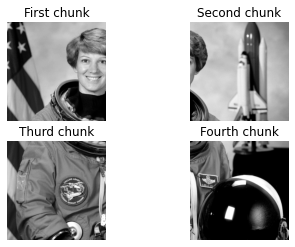

In [17]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.imshow(result[0, ...], cmap='gray')
ax1.imshow(result[1, ...], cmap='gray')
ax2.imshow(result[2, ...], cmap='gray')
ax3.imshow(result[3, ...], cmap='gray')

# Subplot headings
ax0.set_title('First chunk')
ax1.set_title('Second chunk')
ax2.set_title('Thurd chunk')
ax3.set_title('Fourth chunk')

# Don't display axes
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Display images
plt.show(fig)

<a id='joining_images'></a>
## Joining partial images together

Ok, Things are looking pretty good! But how can we join these image chunks together?

So far, we haven't needed any information from neighboring pixels to do our calculations. But there are lots of functions (like those in [dask-image ndfilters](https://dask-image.readthedocs.io/en/latest/dask_image.ndfilters.html)) that *do* need this for accurate results. You could end up with unwanted edge effects if you don't tell dask how your images should be joined.

Dask has several ways to join chunks together: [Stack, Concatenate, and Block](http://docs.dask.org/en/latest/array-stack.html).

Block is very versatile, so we'll use that in this next example. You simply pass in a list (or list of lists) to tell dask the spatial relationship between image chunks.

(512, 512)


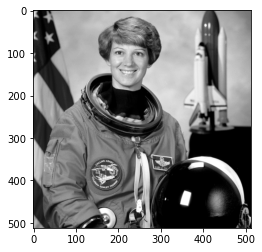

In [18]:
data = [[result[0, ...], result[1, ...]],
        [result[2, ...], result[3, ...]]]
combined_image = da.block(data)
print(combined_image.shape)
plt.imshow(combined_image, cmap='gray')

<a id='segmentation_pipeline'></a>
## A segmentation analysis pipeline

We'll walk through a simple image segmentation and analysis pipeline with three steps:
1. [Filtering]('#filtering)
1. [Segmenting]('#segmenting')
1. [Analyzing]('#analyzing')

<a id='filtering'></a>
### Filtering

Most analysis pipelines require some degree of image preprocessing. dask-image has a number of inbuilt filters available via [dask-image ndfilters](https://dask-image.readthedocs.io/en/latest/dask_image.ndfilters.html)

Commonly a guassian filter may used to smooth the image before segmentation. This causes some loss of sharpness in the image, but can improve segmentation quality for methods that rely on image thresholding.

In [19]:
smoothed_image = dask_image.ndfilters.gaussian_filter(combined_image, sigma=[1, 1])

We see a small amount of blur in the smoothed image.

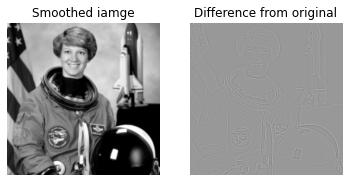

In [20]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(smoothed_image, cmap='gray')
ax1.imshow(smoothed_image - combined_image, cmap='gray')

# Subplot headings
ax0.set_title('Smoothed iamge')
ax1.set_title('Difference from original')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

Since the gaussian filter uses information from neighbouring pixels, the computational graph looks more complicated than the ones we looked at earlier. This is no longer embarrassingly parallel. Where possible dask keeps the computations for each of the four image chunks separate, but must combine information from different chunks near the edges.


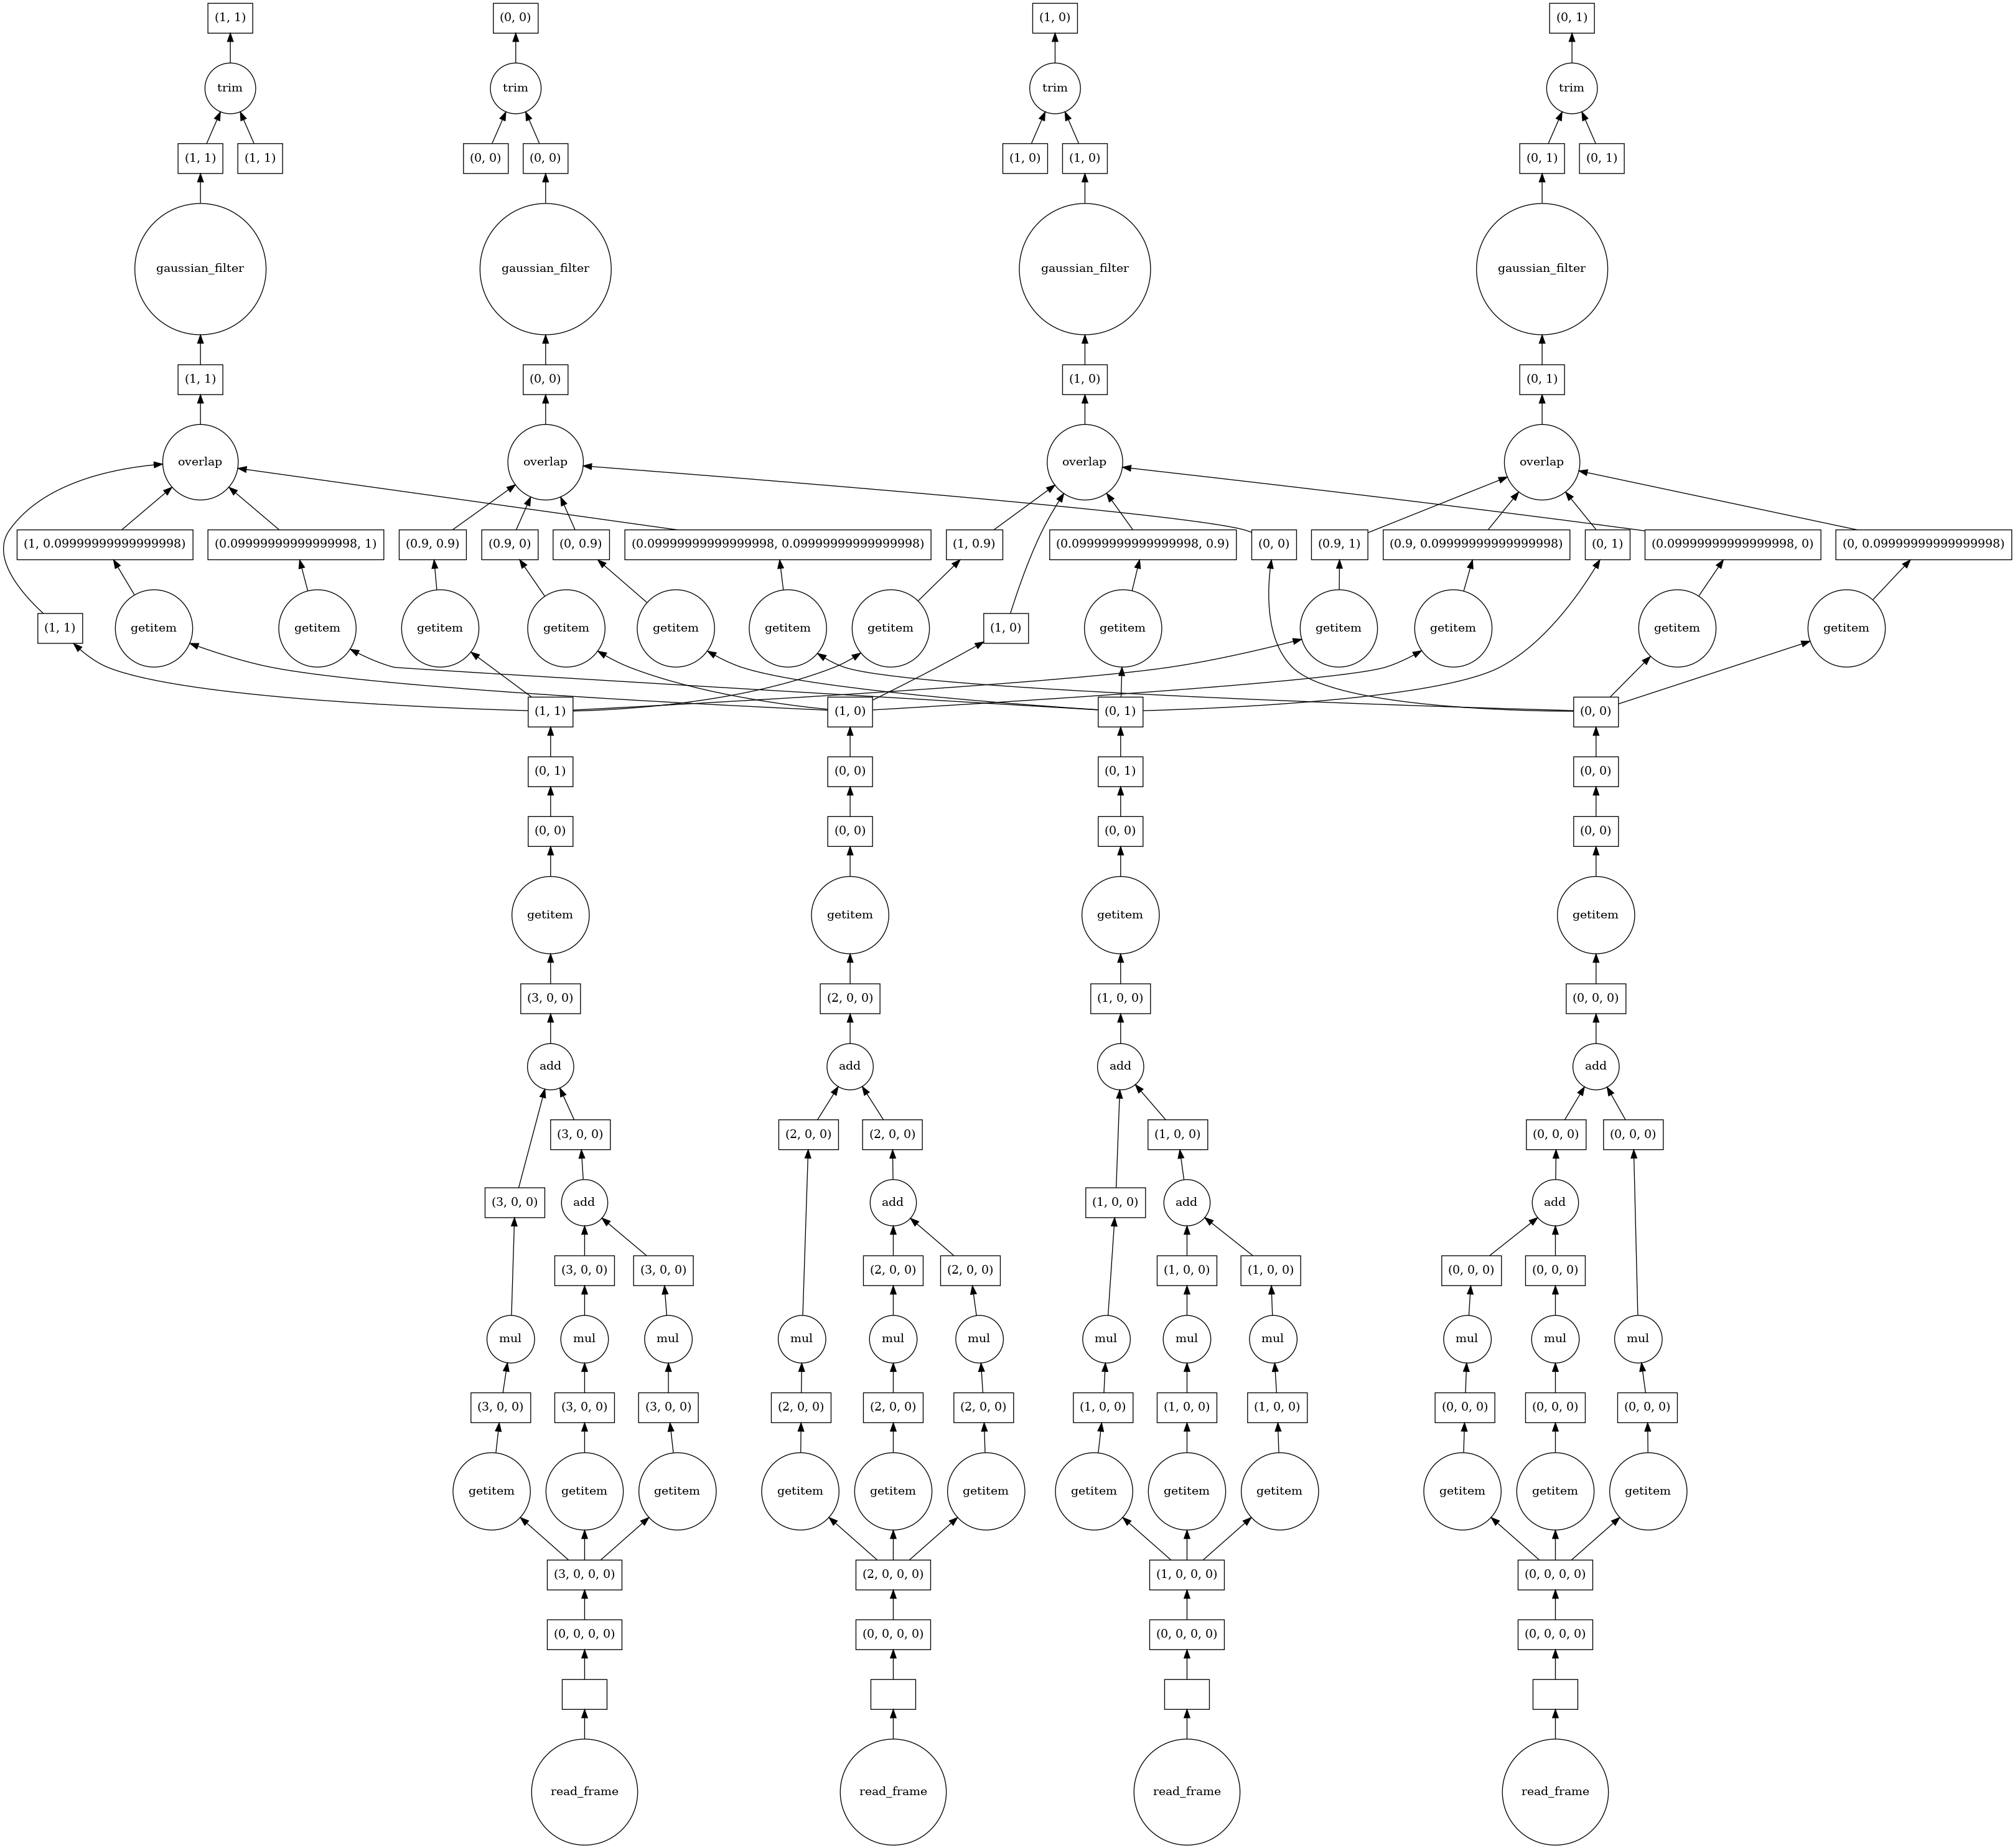

In [21]:
smoothed_image.visualize()

<a id='segmenting'></a>
### Segmenting

After the image preprocessing, we segment regions of interest from the data. We'll use a simple arbitrary threshold as the cutoff, at 75% of the maximum intensity of the smoothed image.

In [22]:
threshold_value = 0.75 * da.max(smoothed_image).compute()
print(threshold_value)

190.5550614819934


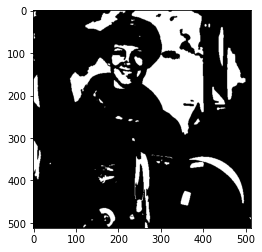

In [23]:
threshold_image = smoothed_image > threshold_value
plt.imshow(threshold_image, cmap='gray')

Next, we label each region of connected pixels above the threshold value. For this we use the `label` function from [dask-image ndmeasure](https://dask-image.readthedocs.io/en/latest/dask_image.ndmeasure.html). This will return both the label image, and the number of labels.

In [24]:
label_image, num_labels = dask_image.ndmeasure.label(threshold_image)

/home/travis/miniconda/envs/test/lib/python3.8/site-packages/dask_image/ndmeasure/__init__.py:214: RuntimeWarning: ``input`` does not have 1 chunk in all dimensions; it will be consolidated first
  warn("``input`` does not have 1 chunk in all dimensions; it will be consolidated first", RuntimeWarning)


Number of labels: 78


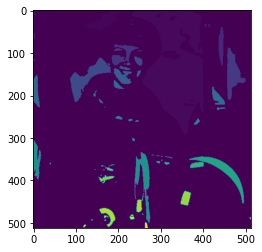

In [25]:
print("Number of labels:", int(num_labels))
plt.imshow(label_image, cmap='viridis')

<a id='analyzing'></a>
### Analyzing

There are a number of inbuilt functions in [dask-image ndmeasure](https://dask-image.readthedocs.io/en/latest/dask_image.ndmeasure.html) useful for quantitative analysis.

We'll use the `dask_image.ndmeasure.mean()` and `dask_image.ndmeasure.standard_deviation()` functions, and apply them to each label region with `dask_image.ndmeasure.labeled_comprehension()`.

In [26]:
index = list(range(int(num_labels)))  # Note that we're including the background label=0 here, too.
out_dtype = float  # The data type we want to use for our results.
default = None     # The value to return if an element of index does not exist in the label image.
mean_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.mean, out_dtype, default, pass_positions=False)
print(mean_values.compute())

[ 90.87492186 194.69185981 207.76964212 215.16959146 196.92609412
 206.50032105 224.71301613 249.08085    217.0948     215.87763779
 211.0477766  205.68146    208.61031956 198.27655577 212.43803803
 201.39967857 210.291275   198.3529809  201.21037636 214.13041176
 200.9344975  201.85547778 194.46485714 202.60302231 205.20927983
 203.72510602 205.94798756 205.88514047 213.67658483 207.33728
 216.13305227 206.7058     211.6957     205.65810758 211.75921279
 197.46586082 202.35786579 199.16034783 216.27194848 200.69137594
 220.99142573 220.1454     239.55       246.5        241.53348
 236.28736    244.84466624 242.09528    203.37236667 209.34061875
 213.76621346 247.53468249 207.66165    234.37771667 224.00188182
 229.2705     232.9163     187.1873     236.16183793 223.7469
 187.813475   227.4778     244.17155    225.49225806 239.4951
 218.7795     252.488826   208.5659     242.99015132 232.4975218
 197.72356    201.98308947 230.57158889 212.82135217 203.13211
 242.21528571 241.32428889 1

Since we're including label 0 in our index, it's not surprising that the first mean value is so much lower than the others - it's the background region below our cutoff threshold for segmentation.

Let's also calculate the standard deviation of the pixel values in our greyscale iamge.

In [27]:
stdev_values = dask_image.ndmeasure.labeled_comprehension(combined_image, label_image, index, dask_image.ndmeasure.standard_deviation, out_dtype, default, pass_positions=False)

Finally, let's load our analysis results into a pandas table and then save it as a csv file.

In [28]:
import pandas as pd

df = pd.DataFrame()
df['label'] = index
df['mean'] = mean_values.compute()
df['standard_deviation'] = stdev_values.compute()

df.head()

,label,mean,standard_deviation
0,0,90.874922,65.452828
1,1,194.691860,2.921235
2,2,207.769642,11.411058
3,3,215.169591,9.193374
4,4,196.926094,5.215053


In [29]:
df.to_csv('example_analysis_results.csv')
print('Saved example_analysis_results.csv')

Saved example_analysis_results.csv


<a id='next_steps'></a>
## Next steps

I hope this guide has helped you to get started with dask-image. 

#### Documentation
You can read more about dask-image in the [dask-image documentation](https://dask-image.readthedocs.io/en/latest/api.html)
and [API reference](https://dask-image.readthedocs.io/en/latest/api.html). Documentation for [dask is here](http://docs.dask.org/en/latest/).

The dask-examples repository has a number of other example notebooks: https://github.com/dask/dask-examples

#### Scaling up with dask distributed
If you want to send dask jobs to a computing cluster for distributed processing, you should take a look at [dask distributed](https://distributed.dask.org/en/latest/). There is also a [quickstart guide available](https://distributed.dask.org/en/latest/quickstart.html).

#### Saving image data with zarr
In some cases it may be necessary to save large data after image processing, [zarr](https://zarr.readthedocs.io/en/stable/) is a python library that you may find useful.

<a id='cleanup'></a>
## Cleaning up temporary directories and files

You recall we saved some example data to the directories `temp/` and `temp-tiles/`. To delete the contents, run the following command:

In [30]:
!rm -r temp

In [31]:
!rm -r temp-tiles